# 第三节：神经网络

第三、四节将向大家介绍基础的神经网络知识及它在 CMS 实验中的应用。我们会涉及：

- 什么是神经网络？它的基本原理是什么？
- 了解一些实战技术、调参细节
- 了解前沿的神经网络：Transformer
- 在 CMS 中的应用：还以之前的di-higgs vs ttbar事例区分为例，训练一个简单神经网络和 Transformer

神经网络 (neural network) 早在上世纪80年代，其概念就已经很成熟，彼时叫做人工神经网络 (ANN)。但是，直到硬件技术足够成熟时，在2012年左右才实现复兴。从此，人们可以训练大而深的神经网络。在大型图像分类 (ImageNet) 竞赛中，深度神经网络取得了非凡的成就。从此人们进入深度学习时代。

神经网络的要素是 ①拥有拟合非线性函数的能力，②具有可以调节的网络参数。

<img src="figures/NN_prototype.png" alt="image" width=500/>

它所从事的任务主要分为分类和回归两种：

<img src="figures/NN_scene.png" alt="image" width=700/>


## 视频介绍

为了最直观地理解神经网络的运作方式，推荐 3Blue1Brown 的科普短片，可视化做的非常好。
https://www.bilibili.com/video/BV1bx411M7Zx/ （有三部）

这里我们快速看下第一部分。带着如下问题观看

 - 神经网络为什么要很多隐藏层？
 - 神经网络为什么设置“激活”层？
 - 神经网络函数的参数以什么为目标进行更新？

后面两部请各位自行观看，主要介绍了：
 - 训练中是怎么更新参数的：梯度下降法
 - 技术上如何实现梯度下降：反向传播算法

## 用简单的神经网络完成事例分类

让我们重新回到之前的 di-Higgs vs ttbar 事例分类的场景中。这次，我们使用上面介绍的最简单的神经网络，这样的神经网络也叫前馈神经网络 (feed-forward network)。原理请见下图。

<img src="figures/NN_for_event_classification.jpg" alt="image" width=900/>


首先，应该选什么框架？目前，PyTorch 框架已基本“打下江山”。此前众多教程中，如果编写基础的神经网络，一般使用 keras 包（以 TensorFlow 为 backend）；而编写复杂网络则直接用 TensorFlow。不过，PyTorch 已经越发成为主流框架。我们在本教程中全面改为 PyTorch。

<img src="figures/software_trend.png" alt="image" width=600/>



下面我们来定义使用PyTorch训练所需的基本要素
 - 模型：做一个PyTorch模型 (nn.Module) 就像搭积木一样，用基础的 nn.BlaBla 积木块搭出你想要的模型。我们在 `__init__` 里初始化自己要的积木块，然后整个网络的运行逻辑写在 forward 里，大功告成！这里我们要写一个简单神经网络，则定义几个 nn.Linear 模块，然后在 forward 里按照 Linear层 -> ReLU激活层 -> Linear层 -> ReLU激活层 -> Linear层 的顺序搭起来即可。
 - 数据集 (DataSet)：这里我们的数据集和上个例子相同，只不过需要用 PyTorch 的专属数据集格式来加载。在这个class里，我们要定义这个数据集的总样本个数 (`__len__`)，和一个 `__getitem__` 函数来 get 到相应 index 下的那个 item。

我们这里借用 pytorch-lightning ，它继续封装包裹了一些常用的 pytorch 设置，让我们代码更简短，并增加可读性。

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch import nn
import torchmetrics

# Define the PyTorch Lightning model
class SimpleFeedForward(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleFeedForward, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) # 定义第一个Linear层
        self.layer2 = nn.Linear(hidden_size, hidden_size) # 定义第二个Linear层
        self.layer3 = nn.Linear(hidden_size, output_size) # 定义第三个Linear层

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=output_size) # 帮助我们计算准确率的
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=output_size)

    def forward(self, x):
        # 把积木搭起来
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

    def training_step(self, batch, batch_idx):
        # 这里是pytorch-lightning的扩展功能，定义每个training step (训练每个batch的时候）之后做什么事情
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_acc(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 这里是pytorch-lightning的扩展功能，定义每个validaiton step (在当前epoch训练结束后，开始validation的每个batch）之后做什么事情
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_acc(logits, y)
        self.log('val_loss', loss)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # 选用什么优化器
        return torch.optim.Adam(self.parameters(), lr=0.001)


# 定义我们的PyTorch dataset, 参见 https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class DataFrameDataset(Dataset):
    def __init__(self, dataframe, input_columns, target_column):
        self.dataframe = dataframe
        self.inputs = dataframe[input_columns].values
        self.targets = dataframe[target_column].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x = torch.tensor(self.inputs[idx], dtype=torch.float32) # N维的待输入网络的特征
        y = torch.tensor(self.targets[idx], dtype=torch.long) # 一维的label
        return x, y

In [2]:
# Load data

import os
# Determine the base directory and the remote git path
hostname = os.uname()[1]
if 'pku.edu.cn' in hostname: # on PKU cluster
    basedir = '/data/pubfs/pku_visitor/public_write/ML/dihiggs_ntuples/'
elif 'thu' in hostname: # on THU cluster
    basedir = '/data/pubfs/pku_visitor/public_write/ML/dihiggs_ntuples/'
elif hostname.startswith('lxslc'): # on IHEP lxslc
    basedir = '/scratchfs/cms/licq/cmschina/ML/dihiggs_ntuples/'
elif hostname.startswith('lxplus'): # on CERN lxplus
    basedir = '/eos/user/c/coli/cmschina/ML/dihiggs_ntuples/'
else:
    raise RuntimeError('Machine not supported')

import uproot
dihiggs = uproot.concatenate(f"{basedir}/hh2b2w.root:tree",library="pd")
ttbar = uproot.concatenate(f"{basedir}/ttbar.root:tree",library="pd")

df = pd.concat([dihiggs, ttbar], axis=0)
df['label'] = df['is_sig'].astype(int) # 定义一个int类型的label，指示是sig还是bkg
df

,event,is_sig,is_bkg,bjet1_pt,bjet1_eta,bjet1_phi,bjet1_eratio,bjet1_mass,bjet1_ncharged,bjet1_nneutrals,...,lep1_charge,lep1_type,lep2_pt,lep2_phi,lep2_eta,lep2_charge,lep2_type,met,met_phi,label
0,0,True,False,191.402328,-0.291164,-0.979666,0.289940,16.695002,12,6,...,1,0,17.508558,1.165262,-0.711694,-1,0,233.613846,2.300718,1
1,1,True,False,68.452507,-1.215415,2.387005,0.492361,15.253864,10,10,...,1,1,50.567219,-1.089323,0.409210,-1,1,102.682526,-0.004101,1
2,2,True,False,152.725433,0.449958,-1.470235,1.215402,12.211457,12,8,...,1,1,43.384056,0.584961,0.624317,-1,0,57.796436,0.935978,1
3,3,True,False,107.360390,0.124028,-1.175005,0.000000,6.060685,6,4,...,1,1,26.664654,2.175398,0.556468,-1,1,65.674774,1.417736,1
4,4,True,False,97.040932,2.160315,-2.940341,0.000000,10.475123,10,14,...,-1,1,29.825296,0.306789,0.310836,1,0,94.994255,-3.043913,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149995,False,True,169.980515,-0.147777,2.985398,0.209411,27.176857,12,8,...,-1,1,92.388741,-0.697610,0.483596,1,1,131.839859,-0.000835,0
149996,149996,False,True,47.205002,1.002193,-1.613720,0.000000,9.505911,10,8,...,-1,0,62.515564,0.693190,0.890577,1,0,75.465065,1.878048,0
149997,149997,False,True,63.940311,0.381228,0.494209,0.166411,8.920477,10,8,...,1,0,34.591877,2.737549,-0.180914,-1,1,59.409447,0.176429,0
149998,149998,False,True,89.012772,-0.562279,-0.638000,0.648749,13.602261,11,12,...,-1,1,20.882822,-3.140386,-1.086141,1,0,44.600636,-1.177096,0


In [3]:
input_columns = ['bjet1_pt', 'bjet1_eta', 'bjet1_phi',
       'bjet1_eratio', 'bjet1_mass', 'bjet1_ncharged', 'bjet1_nneutrals',
       'bjet2_pt', 'bjet2_eta', 'bjet2_phi', 'bjet2_eratio', 'bjet2_mass',
       'bjet2_ncharged', 'bjet2_nneutrals', 'lep1_pt', 'lep1_phi', 'lep1_eta',
       'lep1_charge', 'lep1_type', 'lep2_pt', 'lep2_phi', 'lep2_eta',
       'lep2_charge', 'lep2_type', 'met', 'met_phi']
target_column = 'label'

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1)

# Create datasets
train_dataset = DataFrameDataset(train_df, input_columns, target_column)
val_dataset = DataFrameDataset(val_df, input_columns, target_column)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024)

# Model instance
model = SimpleFeedForward(input_size=26, hidden_size=20, output_size=2)

In [ ]:
# Trainer with a logger
trainer = pl.Trainer(max_epochs=50, logger=pl.loggers.TensorBoardLogger('tb_logs'))

# Fit the model
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratchfs/cms/licq/miniconda/envs/ml/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratchfs/cms/licq/miniconda/envs/ml/lib/python3.9/ ...
Missing logger folder: tb_logs/lightning_logs
2024-01-23 13:20:28.277700: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name      | Type               | Params
-------------------------------------------------
0 | layer1    | Linear             | 540   
1 

Sanity Checking: |                                                                       | 0/? [00:00<?, ?it/s]

/scratchfs/cms/licq/miniconda/envs/ml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


/scratchfs/cms/licq/miniconda/envs/ml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████████████████████████████████████████████████| 264/264 [00:12<00:00, 20.92it/s, v_num=0]
Validation: |                                                                            | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████████████████████████████████████████| 264/264 [00:11<00:00, 22.72it/s, v_num=0]
Validation: |                                                                            | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████████████████| 264/264 [00:13<00:00, 20.03it/s, v_num=0]
Validation: |                                                                            | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████████████████████████████████████████████████| 264/264 [00:11<00:00, 22.56it/s, v_num=0]
Validation: |                                                                            | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████████████████████████████████████████████████| 264/264 [00:11<00:00, 22.19it/s, v

In [8]:
%load_ext tensorboard

In [9]:
%tensorboard --logdir tb_logs

## 我们需要把 TensorBoard 服务的端口绑定到本地端口，就像开启 Jupyter 服务时那样。
## 按照报错信息，如 Reusing TensorBoard on port 6006，则把 6006 端口绑定到本地 6006 端口
## 新开一个本地的shell，然后执行: ssh -L 6006:localhost:6006 <相应lxslc节点>

可以看到这样的 TensorBoard 界面，上面展示了我们指定保存的 train_acc, train_loss, val_acc, val_loss。

<img src="figures/tensorboard_example.png" alt="image" width=600/>


让我们用训练好的model来在测试集上进行神经网络的推理 (inference)，获得输出结果吧！

在标准的神经网络训练的工作流，数据集需要分为三类：训练集 (training dataset)，验证集 (validation dataset) 和测试集。这里我们还用验证集来进行测试。

In [15]:
test_df = val_df

# 这是一个用于predict score的 dataset，返回只包含输入的feature，而不包含label (和上面的 DataFrameDataset 对比一下)
class DataFrameDatasetForInference(Dataset):
    def __init__(self, dataframe, input_columns):
        self.inputs = dataframe[input_columns].values

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = torch.tensor(self.inputs[idx], dtype=torch.float32)
        return x

test_dataset = DataFrameDatasetForInference(test_df, input_columns)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# If your model is saved, load it
# model = SimpleFeedForward.load_from_checkpoint('path_to_checkpoint.ckpt')

# Use the trainer to predict
predictions = trainer.predict(model, dataloaders=test_loader)

# Flatten list of tensors
predictions = [p.numpy() for batch in predictions for p in batch]

Predicting DataLoader 0: 100%|█████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.04it/s]


In [34]:
# 这里的prediction是最后一层网络输出的2个 logits，我们使用 `F.cross_entropy` 来计算交叉熵损失时，它内置了先对 logits 取 softmax
# 所以，我们的这个 logits 没有作 softmax 归一，需要手写一下：

test_score = np.array([np.exp(p[1]) / (np.exp(p[0]) + np.exp(p[1])) for p in predictions]) # 注意，我们取第二个神经元，因为它是signal对应的神经元

(0.0, 1.0)

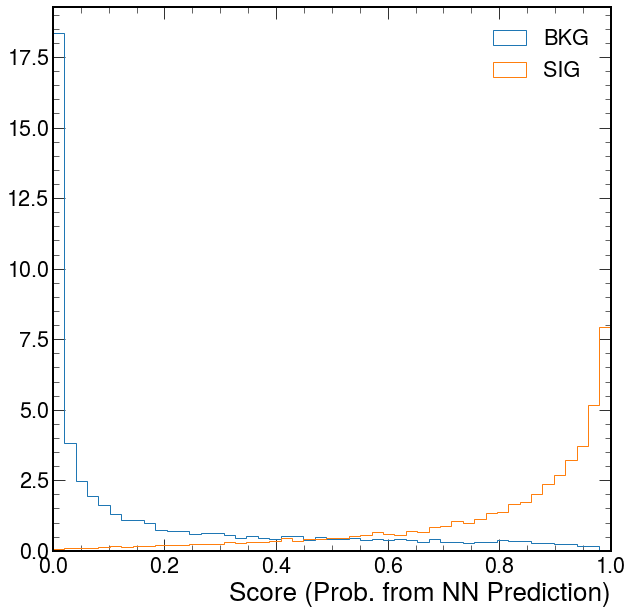

In [35]:
## 下面做出图像

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

plt.hist(test_score[test_df['is_bkg']], label="BKG", histtype="step", bins=np.linspace(0,1), density=True)
plt.hist(test_score[test_df['is_sig']], label="SIG", histtype="step", bins=np.linspace(0,1), density=True)
plt.legend()
plt.xlabel("Score (Prob. from NN Prediction)")
plt.xlim(0,1)

让我们继续做出ROC曲线吧！

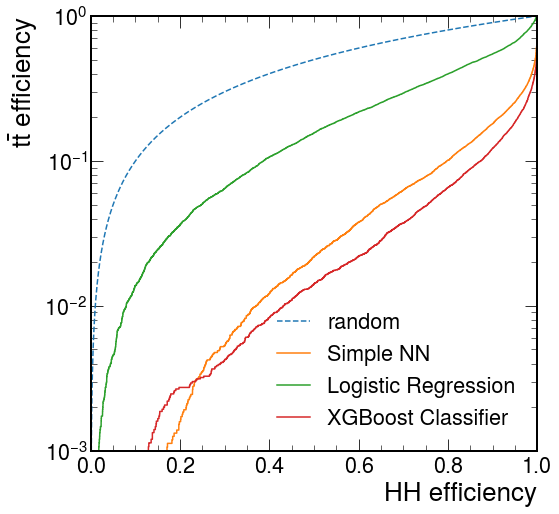

In [36]:
# Draw the ROC curve

import sklearn.metrics as m
fpr, tpr, _thres = m.roc_curve(test_df['is_sig'], test_score)

import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
plt.style.use(hep.style.ROOT)

# Plot the ROC curve
f, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), '--', label='random')
ax.plot(tpr, fpr, label='Simple NN')
## >>continue to draw your new ROC curves here<<
## ...

## below are the loaded ROC curves from the previous ML tasks<<
tpr_clf, fpr_clf = np.loadtxt("data/roc_lr.dat")
tpr_xgb, fpr_xgb = np.loadtxt("data/roc_xgb.dat")
ax.plot(tpr_clf, fpr_clf, label='Logistic Regression')
ax.plot(tpr_xgb, fpr_xgb, label='XGBoost Classifier')

ax.set_yscale('log'); ax.set_xlim(0, 1); ax.set_ylim(1e-3, 1)
ax.set_xlabel('HH efficiency', ha='right', x=1.0); ax.set_ylabel(r'$t\bar{t}$ efficiency', ha='right', y=1.0)
ax.legend()

## 神经网络的调参

### 学习率 (learning rate)：

学习是最重要的超参量，反映训练的每一步按照梯度更新参数的步长，可以以指数为跨度进行调节，最后挑选始终的值。下面展示一个经典的图，表现出不同的学习率下，训练相同轮数后loss的值。
如果学习率过高，则模型基本无法收敛；学习率过低，则模型几乎学不到东西。

<img src="figures/lr_tuning.jpg" alt="image" width=400/>


### 学习率的调度 (learning rate scheduler)

当训练快完成时，loss已经降到很低。我们希望loss能够降到神经网络所能承载的最低值，把神经网络完美地训练完成，需要适当调低learining data。

学习率选用何种模式衰减？阶梯式衰减、指数衰减、余弦退火衰减，在不同的场景下各有应用。
对于基础的神经网络，选择简单的阶梯式或指数衰减即可。

<img src="figures/decay_rate.jpg" alt="image" width=400/>


### 优化器

选用什么方法梯度下降最快？最简单朴素的就是随机梯度下降 (Stochastic Gradient Descent, SGD)，是在当前批的样本，计算一个梯度，然后下降。很显然当前批 (例如，1024个样本）仅是总样本很小的一部分，因此这个梯度颇有随机性。SGD 导致 loss 下降的效率不高，可能在鞍点处震荡。

一个很显然的改进就是增加一个 momentum，让之前下降的惯性能够影响当前下降的方向。这其实相当于结合了很多批样本，共同决定一个梯度的方向，效率就高很多。

优化器的研究已经很成熟，例如 Adam 优化器。往往不需要特别调节优化器。更详细的介绍，可参见这个[知乎文章](https://zhuanlan.zhihu.com/p/32626442)。

<img src="figures/optimizer.gif" alt="image" width=400/>

### 过拟合 (overfitting)

过拟合的表现是 loss 在训练样本上始终下降，但每轮 epoch 结束后在测试样本上运行发现不再下降，甚至有所上升。这说明训练集。往往在训练集较小，而网络参数量较大时容易出现过拟合。

过拟合解决方案：对于训练普通前馈神经网络网络，可简单调节网络层数，隐藏层的维度。

对于复杂网络的训练，可以:
 - 设置 dropout：在训练中随机丢掉一些神经元，故连接它们的权重不再传递到后面的层。可以设置dropout率，比如0.1.
 - 设置 weight decay (L2 正则项): 把所有网络参数的平方添加到 loss function 里面，这样可以要求每个网络的参数值不会特别大，从而限制神经网络的拟合能力。

<img src="figures/overfitting.jpg" alt="image" width=200/>
<img src="figures/overfitting_example.png" alt="image" width=500/>


看看我们刚才的训练，有没有出现过拟合呢？

在上面的例子里多试几种不同的神经网络参数设置，然后比较一下它们的训练结果吧！